In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/KAGGLE_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kenjee/z-by-hp-unlocked-challenge-3-signal-processing

Dataset URL: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing
License(s): CC-BY-NC-SA-4.0
 99% 600M/604M [00:07<00:00, 61.4MB/s]
100% 604M/604M [00:07<00:00, 89.8MB/s]


In [ ]:
! unzip z-by-hp-unlocked-challenge-3-signal-processing.zip

Archive:  z-by-hp-unlocked-challenge-3-signal-processing.zip
  inflating: Forest Recordings/recording_00.mp3  
  inflating: Forest Recordings/recording_01.mp3  
  inflating: Forest Recordings/recording_02.mp3  
  inflating: Forest Recordings/recording_03.mp3  
  inflating: Forest Recordings/recording_04.mp3  
  inflating: Forest Recordings/recording_05.mp3  
  inflating: Forest Recordings/recording_06.mp3  
  inflating: Forest Recordings/recording_07.mp3  
  inflating: Forest Recordings/recording_08.mp3  
  inflating: Forest Recordings/recording_09.mp3  
  inflating: Forest Recordings/recording_10.mp3  
  inflating: Forest Recordings/recording_11.mp3  
  inflating: Forest Recordings/recording_12.mp3  
  inflating: Forest Recordings/recording_13.mp3  
  inflating: Forest Recordings/recording_14.mp3  
  inflating: Forest Recordings/recording_15.mp3  
  inflating: Forest Recordings/recording_16.mp3  
  inflating: Forest Recordings/recording_17.mp3  
  inflating: Forest Recordings/recordin

In [ ]:
!pip install tensorflow-io
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono('/content/Parsed_Capuchinbird_Clips/XC3776-3.wav')
nwave = load_wav_16k_mono('/content/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav')

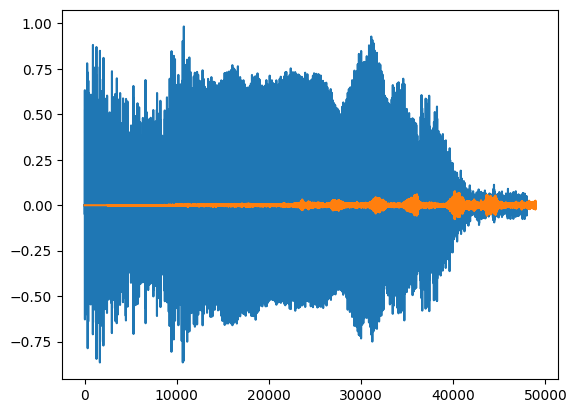

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS = os.path.join('/content/Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/Parsed_Not_Capuchinbird_Clips')

In [ ]:
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')


In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
lengths = []
for file in os.listdir(os.path.join('/content/Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

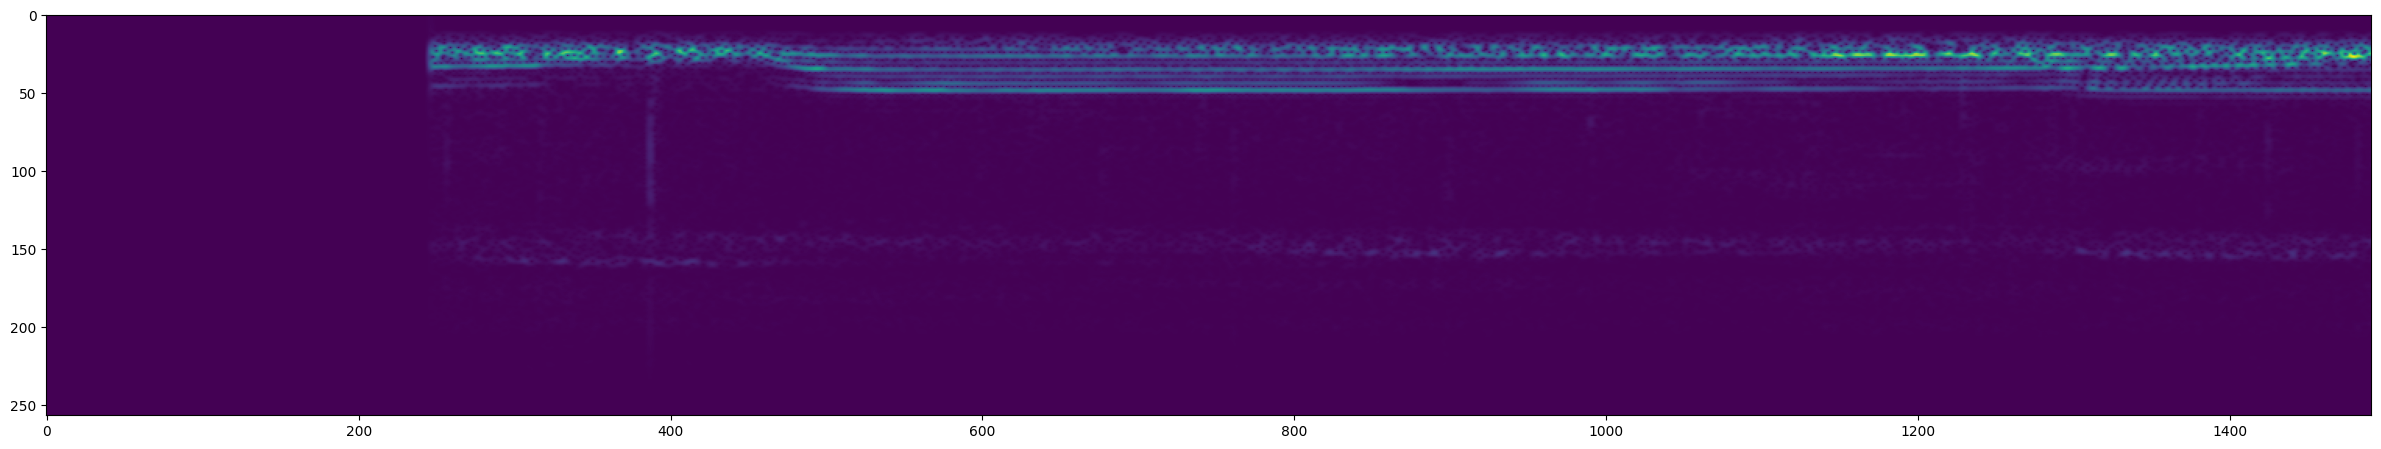

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
capuchin_files = [os.path.join('/content/Parsed_Capuchinbird_Clips', f) for f in os.listdir('/content/Parsed_Capuchinbird_Clips') if f.endswith('.wav')]
not_capuchin_files = [os.path.join('/content/Parsed_Not_Capuchinbird_Clips', f) for f in os.listdir('/content/Parsed_Not_Capuchinbird_Clips') if f.endswith('.wav')]

# Create TensorFlow datasets
capuchin_ds = tf.data.Dataset.from_tensor_slices((capuchin_files, [1] * len(capuchin_files)))
not_capuchin_ds = tf.data.Dataset.from_tensor_slices((not_capuchin_files, [0] * len(not_capuchin_files)))

# Combine the datasets
data = capuchin_ds.concatenate(not_capuchin_ds)


In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)

    # Pad or trim the waveform to ensure a fixed length (1 second at 16000 Hz)
    wav = wav[:16000]  # Use the first second of audio
    wav = tf.pad(wav, [[0, 16000 - tf.shape(wav)[0]]])  # Zero padding if shorter than 1 second

    # Create a spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    # Resize the spectrogram to a fixed shape (e.g., 129, 129)
    spectrogram = tf.image.resize(tf.expand_dims(spectrogram, axis=-1), [129, 129])

    return spectrogram, label

# Apply preprocess function
data = data.map(preprocess).shuffle(buffer_size=6).batch(2).prefetch(tf.data.AUTOTUNE)

# Optional: Create training and validation sets (80/20 split)
data_size = len(capuchin_files) + len(not_capuchin_files)
train_size = int(0.8 * data_size)
train_data = data.take(train_size)
test_data = data.skip(train_size)

# Define the model with a fixed input shape
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(129, 129, 1)),  # Fixed input shape
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])



# Train the model with validation
hist = model.fit(data, epochs=4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
405/405 ━━━━━━━━━━━━━━━━━━━━ 127s 309ms/step - accuracy: 0.9725 - loss: 0.3238 - precision: 0.9745 - recall: 0.9803
Epoch 2/4
405/405 ━━━━━━━━━━━━━━━━━━━━ 125s 267ms/step - accuracy: 0.8693 - loss: 2.4937 - precision: 0.9240 - recall: 0.8630
Epoch 3/4
405/405 ━━━━━━━━━━━━━━━━━━━━ 145s 275ms/step - accuracy: 0.8673 - loss: 1.3561 - precision: 0.9032 - recall: 0.8760
Epoch 4/4
405/405 ━━━━━━━━━━━━━━━━━━━━ 106s 261ms/step - accuracy: 0.8817 - loss: 3.6127 - precision: 0.9492 - recall: 0.8632


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 127, 127, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 63504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,128,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,386,789 (93.03 MB)

 Trainable params: 8,128,929 (31.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,257,860 (62.02 MB)

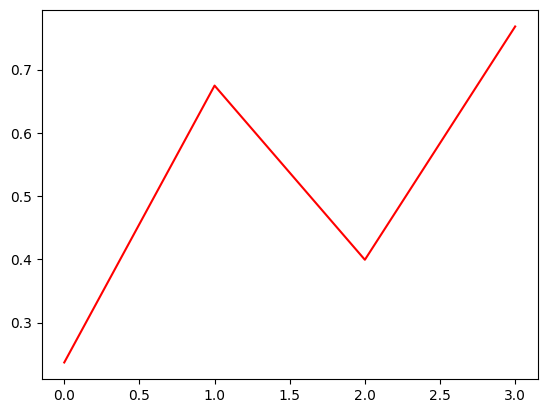

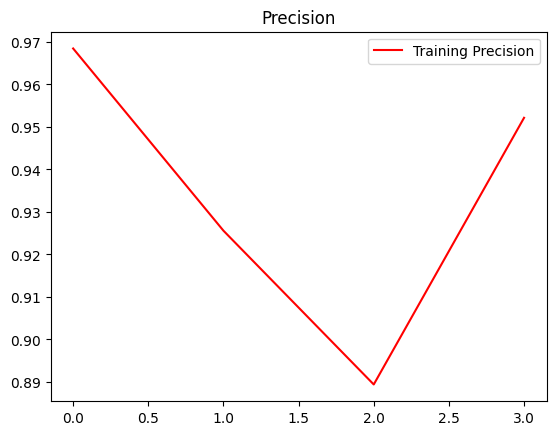

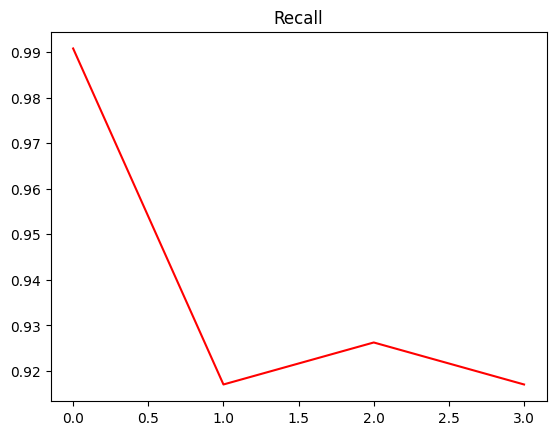

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], 'r')  # Plot training loss
plt.show()

plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label='Training Precision')   # Plot training precision
plt.legend()
plt.show()

plt.title('Recall')
plt.plot(hist.history['recall'], 'r')

plt.show()

In [ ]:
X_test, y_test = next(iter(test_data))
yhat = model.predict(X_test)

# Convert predictions to binary labels
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# Calculate and print precision, recall, and accuracy for the test set
from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision:", precision_score(y_test, yhat))
print("Recall:", recall_score(y_test, yhat))
print("Accuracy:", accuracy_score(y_test, yhat))


StopIteration: 

In [ ]:
# Loop over the test data to collect predictions and labels
y_true = []
y_pred = []

for X_batch, y_batch in test_data:
    yhat_batch = model.predict(X_batch)
    yhat_batch = [1 if prediction > 0.5 else 0 for prediction in yhat_batch]

    # Append the true labels and predicted labels for the entire test set
    y_true.extend(y_batch.numpy())
    y_pred.extend(yhat_batch)

# Calculate and print precision, recall, and accuracy for the entire test set
from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("Accuracy:",accuracy_score(y_true, y_pred))


Precision: 0.0
Recall: 0.0
Accuracy: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('/content/Forest Recordings/recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:16000]  # Trim or pad to 1 second at 16kHz
    wav = tf.pad(wav, [[0, 16000 - tf.shape(wav)[0]]])  # Zero pad if shorter

    # Create a spectrogram and resize it to (129, 129)
    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(tf.expand_dims(spectrogram, axis=-1), [129, 129])

    return spectrogram, label


In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = "/content/Forest Recordings/recording_18.mp3"


In [ ]:
wav = load_mp3_16k_mono(mp3)


In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [ ]:
# Assuming `audio_slices` is a batch of audio signals you want to predict on
def preprocess_input(audios):
    # Apply the same preprocessing used during training
    spectrograms = []

    # Iterate through each audio file path
    for audio in audios:
        wav = load_wav_16k_mono(audio)  # Load the audio file
        wav = wav[:16000]  # Trim or pad to 1 second
        wav = tf.pad(wav, [[0, 16000 - tf.shape(wav)[0]]])  # Zero padding if shorter than 1 second

        # Create a spectrogram
        spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=128)
        spectrogram = tf.abs(spectrogram)

        # Resize the spectrogram
        spectrogram = tf.image.resize(tf.expand_dims(spectrogram, axis=-1), [129, 129])
        spectrograms.append(spectrogram)

    return tf.convert_to_tensor(spectrograms)

# Example paths to audio files you want to predict on
audio_slices = [
    '/content/Parsed_Capuchinbird_Clips/XC3776-0.wav',
    '/content/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav',
    # Add more file paths as needed
]

# Preprocess the audio files
preprocessed_input = preprocess_input(audio_slices)

# Make predictions using the model
yhat = model.predict(preprocessed_input)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [ ]:
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

1

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{}

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed


{}

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [ ]:
import csv

# Assuming postprocessed is your dictionary with results
postprocessed = {
    'recording_1.mp3': 1,
    'recording_2.mp3': 0,
    # Add more recordings as needed
}

# Save results to a CSV file and print them
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])  # Write the header
    for key, value in postprocessed.items():  # Ensure to reference the complete dictionary
        writer.writerow([key, value])  # Write to CSV
        print(f'Recording: {key}, Capuchin Calls: {value}')  # Print each entry



Recording: recording_1.mp3, Capuchin Calls: 1
Recording: recording_2.mp3, Capuchin Calls: 0
